In [2]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from adjustText import adjust_text

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject 

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

import sys
import os

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [3]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [4]:
# locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)

# matrix.set_index(matrix.index.astype(str),inplace=True)
# locations.set_index(matrix.index.astype(str),inplace=True)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/
with open(f'{filepath}{roi_name}/exports/sg_object_20240604_dilate10.pkl', 'rb') as f:
    sg_obj = pickle.load(f)


In [5]:
# set object id (as string) as index

matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix['object_id']]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

No filtering available or applied.


In [6]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

In [7]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

In [8]:
cutoff = 4

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


In [9]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

In [10]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

In [11]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

In [12]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=15) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [13]:
np.sum(adata_genes.X)

8742922.0

In [14]:
total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

In [15]:
threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

In [16]:
cluster_name_cutoff = 3


obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cluster_name_cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

0 ['bc_009', 'bc_091']
1 ['bc_085']
2 ['bc_063', 'bc_066']
3 ['bc_094']
4 ['bc_066']
5 ['bc_003', 'bc_009']
6 ['bc_067', 'bc_094']
7 ['bc_001', 'bc_029', 'bc_031', 'bc_033', 'bc_087']
8 ['bc_007', 'bc_013', 'bc_054', 'bc_060']
9 ['bc_006', 'bc_018', 'bc_043']
10 ['bc_021', 'bc_049', 'bc_079']
11 ['bc_019', 'bc_025', 'bc_074', 'bc_092']
12 ['bc_074', 'bc_083']
13 ['bc_008', 'bc_040', 'bc_067']
14 ['bc_037']
15 ['bc_001', 'bc_024', 'bc_029', 'bc_031', 'bc_066', 'bc_087', 'bc_091']
16 ['bc_016', 'bc_040', 'bc_052', 'bc_092', 'bc_093']
17 ['bc_022', 'bc_030', 'bc_060']
18 ['bc_060']
19 ['bc_001', 'bc_022', 'bc_087']
20 ['bc_026', 'bc_031', 'bc_041']
21 ['bc_021', 'bc_028', 'bc_060', 'bc_067', 'bc_074']
22 ['bc_003', 'bc_009', 'bc_066', 'bc_087']
23 ['bc_085']
24 ['bc_010', 'bc_024', 'bc_025', 'bc_041']
25 ['bc_031', 'bc_047', 'bc_093']
26 ['bc_008', 'bc_035', 'bc_059', 'bc_063', 'bc_074', 'bc_081']
27 ['bc_066', 'bc_091']
28 ['bc_008', 'bc_041', 'bc_096']
29 ['bc_016']
30 ['bc_002', 'bc_06

In [17]:
adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

In [18]:


triple_bc_clusters = adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 3]    

cs,counts = np.unique([int(x) for x in triple_bc_clusters['bc_cluster'].values],return_counts=True)

cs[np.argsort(counts)[::-1]]

array([ 311,  372,   91, ..., 2109, 2114, 3424])

In [19]:
clusters_to_show = []

for clu,count in zip(cs[np.argsort(counts)[::-1]],counts[np.argsort(counts)[::-1]]):
    if count > 20:
        clusters_to_show.append(clu)
        print(clu,count,cluster_n_found_barcodes[clu],cluster_barcode_names[clu])

311 1388 4 bc_001-bc_029-bc_031-bc_087
372 1150 5 bc_029-bc_059-bc_064-bc_068-bc_085
91 415 3 bc_041-bc_066-bc_093
1214 389 4 bc_025-bc_060-bc_062-bc_066
39 374 6 bc_030-bc_040-bc_058-bc_059-bc_083-bc_095
1096 368 3 bc_009-bc_014-bc_021
512 366 3 bc_028-bc_038-bc_053
238 342 4 bc_019-bc_040-bc_041-bc_052
1114 332 4 bc_041-bc_045-bc_047-bc_052
644 236 4 bc_006-bc_019-bc_064-bc_094
31 195 3 bc_025-bc_079-bc_083
277 187 7 bc_025-bc_039-bc_047-bc_058-bc_059-bc_076-bc_079
1101 185 3 bc_050-bc_065-bc_089
256 182 5 bc_004-bc_013-bc_048-bc_066-bc_083
332 177 3 bc_024-bc_048-bc_060
8 172 4 bc_007-bc_013-bc_054-bc_060
258 163 4 bc_001-bc_005-bc_025-bc_030
71 162 4 bc_021-bc_028-bc_060-bc_067
72 161 3 bc_067-bc_077-bc_087
78 151 3 bc_017-bc_085-bc_087
42 146 3 bc_004-bc_041-bc_077
207 146 3 bc_048-bc_059-bc_081
161 146 4 bc_013-bc_024-bc_082-bc_091
92 138 3 bc_021-bc_058-bc_070
1394 136 3 bc_008-bc_084-bc_086
26 135 6 bc_008-bc_035-bc_059-bc_063-bc_074-bc_081
100 124 5 bc_001-bc_024-bc_029-bc_031

In [20]:
sg_obj.gdf['cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in sg_obj.gdf.index]

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


<AxesSubplot: >

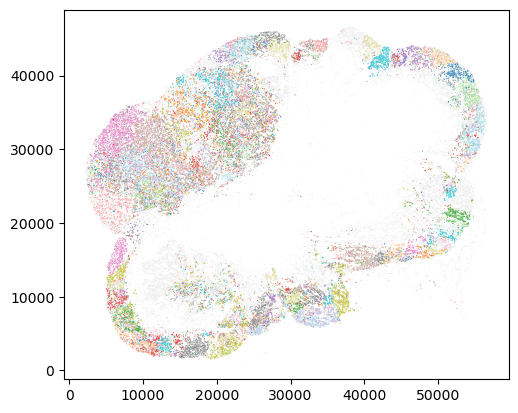

In [21]:
sg_obj.gdf['bc_cluster_not_nan'] = [cluster if not np.isnan(cluster) else 9999999 for cluster in sg_obj.gdf['cluster'] ] 

color_dict = {}
for c,cluster in enumerate(np.unique(sg_obj.gdf['bc_cluster_not_nan'])):

    color_dict[cluster] = sns.color_palette('tab20',n_colors=len(np.unique(sg_obj.gdf['bc_cluster_not_nan'])))[c]
color_dict[9999999] = (0.5,0.5,0.5,0.1)
color_list = [color_dict[cluster] for cluster in sg_obj.gdf['bc_cluster_not_nan']]

sg_obj.gdf.plot(color=color_list)

In [22]:
sns.color_palette('tab20',n_colors=len(np.unique(sg_obj.gdf['bc_cluster_not_nan'])))[c]

(0.596078431372549, 0.8745098039215686, 0.5411764705882353)

In [23]:
cell_gene_table_df = sg_obj.get_cell_gene_table_df()
cell_gene_table_df['object_id'] = [str(int(x)) for x in cell_gene_table_df['object_id']]

No filtering available or applied.


In [24]:
fractions = []
hi_clus = []

hi_clu_dict = {}

gene_cutoff = 25


cell_ids_high = df[df['IGFBP7'] > cutoff]['cell_id']

clus,counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
for (bc_clu,hi_count) in zip(clus,counts):
    if ~np.isnan(bc_clu):
        # print(bc_clu)
        all_count = len(adata_genes[adata_genes.obs['bc_cluster']==bc_clu])
        if all_count > 10:
            hi_clus.append(bc_clu)
            fractions.append(hi_count/all_count)
            hi_clu_dict[bc_clu] = hi_count/all_count


In [25]:
all_clus, all_counts = np.unique(adata_genes.obs['bc_cluster'],return_counts = True)

clus_of_interest = []
for clu,count in zip(all_clus,all_counts):
    if count > 5:
        clus_of_interest.append(clu)


In [26]:
big_clus = adata_genes[adata_genes.obs['bc_cluster'].isin(clus_of_interest)]

# big_clus[big_clus['']]

# fraction_here = len

In [27]:
clus,counts = np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)

cluster_counts = {clu:count for (clu,count) in zip(clus,counts)}

In [28]:
# determine whether IGFBP7 high cells are enriched per clone.

hi_cluster,hi_counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
all_cluster,all_counts =  np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)


In [29]:
fractions = []

for clu, all_count in zip(all_cluster,all_counts):
    if clu in hi_cluster:
        if all_count > 10:
            fractions.append(hi_counts[np.where(hi_cluster==clu)[0][0]]/all_count)
    else:
        if all_count > 10:
            fractions.append(0)

In [30]:
sg_obj.get_cell_gene_table_df()


No filtering available or applied.


object_id  AKT1  AXL  BGN  BIRC3  BIRC5  BMP2  BMP4  CALD1  CAPG  ...  \
0            1.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   0.0  ...   
1            2.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   
2            3.0   0.0  0.0  0.0    0.0    1.0   0.0   0.0    3.0   3.0  ...   
3            4.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   0.0  ...   
4            7.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   
...          ...   ...  ...  ...    ...    ...   ...   ...    ...   ...  ...   
67197    67193.0   2.0  0.0  6.0    0.0    1.0   0.0   0.0    9.0  14.0  ...   
67198    67199.0   0.0  0.0  0.0    0.0    1.0   0.0   0.0    7.0  10.0  ...   
67199    67200.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   5.0  ...   
67200    67201.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    2.0   1.0  ...   
67201    67202.0   0.0  0.0  1.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   

       bc_087  bc_088  bc_089  bc_090  bc_091  bc_092  bc_093  bc_094  bc_095  \
0         0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
67197     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67198     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67199     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67200     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67201     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       bc_096  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
67197     0.0  
67198     0.0  
67199     0.0  
67200     0.0  
67201     0.0  

[67202 rows x 216 columns]

In [31]:
sg_obj.gdf['cell_id'] = sg_obj.gdf.index
sg_obj.gdf['object_id'] = sg_obj.gdf.index

In order to determine whether there are genes that have intrinsic patterns of expression by clone, we are going to calculate average expression per clone, 

In [32]:
confident_clusters = adata_genes[(~np.isnan(adata_genes.obs['bc_cluster'])) & (adata_genes.obs['bc_cluster_n_bcs'] > 2) ]

clus,clus_counts = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

clus_enough_cells = []

for clu,count in zip(clus,clus_counts):
    if count >= 25:
        clus_enough_cells.append(clu)

    print(clu,count)

confident_clusters = confident_clusters[confident_clusters.obs['bc_cluster'].isin(clus_enough_cells)]

# confident_clusters = adata_genes.obs.groupby('bc_cluster')
# confident_clusters = confident_clusters.filter(lambda x: len(x) > 5)

7.0 9
8.0 172
9.0 4
10.0 49
11.0 2
13.0 2
15.0 2
16.0 58
17.0 39
19.0 7
20.0 2
21.0 2
22.0 23
24.0 7
25.0 8
26.0 135
28.0 75
31.0 195
35.0 10
36.0 2
38.0 5
39.0 374
41.0 13
42.0 146
43.0 6
44.0 4
45.0 2
46.0 6
47.0 14
49.0 47
51.0 10
52.0 7
53.0 3
55.0 76
56.0 6
57.0 34
60.0 2
64.0 2
65.0 8
69.0 3
71.0 162
72.0 161
75.0 6
76.0 2
77.0 5
78.0 151
82.0 22
83.0 13
86.0 3
88.0 14
90.0 7
91.0 415
92.0 138
93.0 19
94.0 9
95.0 2
97.0 85
100.0 124
104.0 4
109.0 92
112.0 14
113.0 2
114.0 2
116.0 3
117.0 3
121.0 2
122.0 4
123.0 6
125.0 2
127.0 9
128.0 3
130.0 4
134.0 3
137.0 7
141.0 6
143.0 3
145.0 6
148.0 2
150.0 3
153.0 4
155.0 44
156.0 6
157.0 97
161.0 146
165.0 3
167.0 10
171.0 4
172.0 8
173.0 5
175.0 28
176.0 64
181.0 4
182.0 2
186.0 56
189.0 14
190.0 2
193.0 5
195.0 61
196.0 20
198.0 15
200.0 27
201.0 3
204.0 22
205.0 4
206.0 2
207.0 146
208.0 112
209.0 6
213.0 22
216.0 2
218.0 8
219.0 30
220.0 2
222.0 12
225.0 2
226.0 5
228.0 36
229.0 2
230.0 2
232.0 10
236.0 4
237.0 109
238.0 342
240.0 2


In [33]:
confident_clusters

View of AnnData object with n_obs × n_vars = 11152 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

In [34]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    # print(out)
    return out

def grouped_obs_sum_squares(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.square(X).mean(axis=0, dtype=np.float64)).tolist()

    # print(out)
    return out

def grouped_obs_fraction(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.count_nonzero(X,axis=0)/X.shape[0]).tolist()

    # print(out)
    return out

def grouped_obs_fraction_cutoff(adata, group_key,cutoff = 1, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.sum(X>=cutoff,axis=0)/X.shape[0]).tolist()

    # print(out)
    return out

def grouped_obs_fraction_quantile(adata, group_key,q=0.9, layer=None, gene_symbols=None):
# def grouped_obs_fraction_quantile(adata, group_key,q=0.5, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.sum(X>=np.quantile(getX(adata),q=q,axis=0),axis=0)/X.shape[0]).tolist()

    # print(out)
    return out

def grouped_obs_median(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.median(X,axis=0)).tolist()

    # print(out)
    return out


def grouped_obs_ttest(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )
    out_p = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    all_X = getX(adata)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])

        X = getX(adata[idx])
        t = scipy.stats.ttest_ind(confident_clusters[idx].X,confident_clusters.X,equal_var=False)
        # print(t.statistic.shape)
        out[group] = t.statistic

        # out[group] = np.ravel(np.median(X,axis=0)).tolist()

    # print(out)
    return out

In [35]:
def grouped_obs_ttest_big(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )
    out_p = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    all_X = getX(adata)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])

        X = getX(adata[idx])
        t = scipy.stats.ttest_ind(confident_clusters[idx].X,confident_clusters.X,equal_var=False)
        # print(t.statistic.shape)
        out[group] = t.statistic
        out_p[group] = t.pvalue

        # out[group] = np.ravel(np.median(X,axis=0)).tolist()

    # print(out)
    return out, out_p

def grouped_obs_fold_change(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    all_X = getX(adata)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])

        # t = scipy.stats.ttest_ind(confident_clusters[idx].X,confident_clusters.X,equal_var=False)
        # print(t.statistic.shape)
        # out[group] = np.log2(np.mean(X,axis=0)/np.mean(all_X,axis=0))

        # vals = np.log2(np.mean(X,axis=0)/np.mean(all_X,axis=0))

        # vals = np.nan_to_num(vals, neginf=0, posinf=0, nan=0) 
        # vals = np.mean(X,axis=0)
        # # vals[vals == -inf] = 0

        # out[group] = vals.tolist()

        out[group] = np.log2(np.nan_to_num(np.divide(np.mean(X,axis=0), np.mean(all_X,axis=0)), nan=1)).tolist()
        # out[group] = np.log(np.mean(X,axis=0))-np.log(np.mean(all_X,axis=0))
        # out_p[group] = t.pvalue

        # out[group] = np.ravel(np.median(X,axis=0)).tolist()

    # print(out)
    return out

In [36]:
gene_by_bc_cluster_log2fc = grouped_obs_fold_change(confident_clusters,'bc_cluster')


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_10281/1460340711.py:77: RuntimeWarning: divide by zero encountered in log2
  out[group] = np.log2(np.nan_to_num(np.divide(np.mean(X,axis=0), np.mean(all_X,axis=0)), nan=1)).tolist()


In [37]:
gene_by_bc_cluster_here_stat,gene_by_bc_cluster_here_p = grouped_obs_ttest_big(confident_clusters,'bc_cluster')
gene_by_bc_cluster_log2fc  = grouped_obs_fold_change(confident_clusters,'bc_cluster')
gene_by_bc_cluster_mean = grouped_obs_mean(confident_clusters,'bc_cluster')

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_10281/1460340711.py:77: RuntimeWarning: divide by zero encountered in log2
  out[group] = np.log2(np.nan_to_num(np.divide(np.mean(X,axis=0), np.mean(all_X,axis=0)), nan=1)).tolist()


In [38]:
gene_by_bc_cluster_log2fc

8.0       10.0      16.0      17.0      26.0      28.0      31.0    \
AKT1  -0.038423 -0.053220  0.688559  0.246030  0.294152 -0.301457  0.155146   
AXL   -1.102265      -inf  0.466019 -0.283331 -0.489782 -2.226747 -1.605259   
BGN    0.644772 -2.371492  1.692665  1.200672 -1.040049  1.516899 -0.543083   
BIRC3 -0.911987 -0.100432  0.656297 -0.771125 -0.562538 -0.714541 -0.093053   
BIRC5  0.321366  0.051283  0.537050  0.299290  0.200252 -0.229089  0.195267   
...         ...       ...       ...       ...       ...       ...       ...   
VGF   -4.410029 -1.598474  2.035999 -3.006132  0.411908 -1.727156 -0.067532   
WNT5A  0.183561  0.120647  0.877376      -inf  0.073578  0.243503  0.128026   
YAP1  -0.646895 -0.149448 -0.110320  0.725293  0.378665  0.419307 -0.211971   
ZEB1  -3.116959 -0.720442  0.451325 -0.976097  0.554418  0.250412  0.161407   
ZEB2  -0.896268 -0.645428 -0.279890  0.316147  0.038143 -0.241615 -0.139798   

         39.0      42.0      49.0    ...    1214.0    1254.0    1315.0  \
AKT1   0.142603  0.684642 -0.505549  ... -0.170374 -1.600302 -0.256014   
AXL    1.155617  0.812247 -1.552518  ... -0.142123      -inf  1.680143   
BGN    0.886148 -1.444107 -1.410907  ...  0.767500 -0.710979  1.216033   
BIRC3 -1.032617 -0.090585 -1.040311  ... -0.089349      -inf  0.870421   
BIRC5  0.165288  0.054528 -0.434565  ... -0.074890 -3.478028  0.041765   
...         ...       ...       ...  ...       ...       ...       ...   
VGF   -0.643133  1.190984 -1.860281  ... -0.920634 -4.259889 -1.364586   
WNT5A  0.127062  0.867460  0.180768  ...  0.131730 -0.803802      -inf   
YAP1  -0.384196 -0.261591  0.701219  ...  0.240896 -0.891033 -0.481158   
ZEB1  -0.652627  0.704443  0.339679  ... -0.593881      -inf -0.334551   
ZEB2  -0.456598  0.101385  0.432615  ... -0.428796 -0.262449 -0.674575   

         1383.0    1394.0    1408.0    1510.0    1534.0    1590.0    3176.0  
AKT1   0.649633 -0.916433 -0.783166 -0.769236  0.094471 -0.038423  0.586068  
AXL   -0.752816  0.821499  0.632837  0.301632 -1.830819      -inf  0.417109  
BGN   -4.418561  1.510959 -0.663673  0.050925  0.058026  0.063309 -4.248635  
BIRC3 -0.240610 -1.573185 -0.439919  1.228875 -1.318612 -0.343703 -1.070685  
BIRC5  0.078833  0.003415  0.165828 -1.285672  0.035595 -0.427617  0.366939  
...         ...       ...       ...       ...       ...       ...       ...  
VGF    1.846311 -2.223230 -0.011961 -3.591094 -1.679151 -0.163673  1.016236  
WNT5A      -inf  0.522363      -inf -0.135008 -0.682496      -inf  2.024863  
YAP1   0.024482  0.087209 -0.306071 -0.274707 -0.219530  0.352023  0.063163  
ZEB1   0.876346 -0.456229 -0.059928  1.193828 -1.523584 -0.548675 -0.275657  
ZEB2   0.140393 -0.022257 -0.499488  0.005807  0.172015 -0.210628  0.271844  

[119 rows x 84 columns]

In [39]:
adata_genes.var_names

Index(['AKT1', 'AXL', 'BGN', 'BIRC3', 'BIRC5', 'BMP2', 'BMP4', 'CALD1', 'CAPG',
       'CCNA2',
       ...
       'TRPM1', 'TYR', 'VCAM1', 'VEGFA', 'VEGFC', 'VGF', 'WNT5A', 'YAP1',
       'ZEB1', 'ZEB2'],
      dtype='object', length=119)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


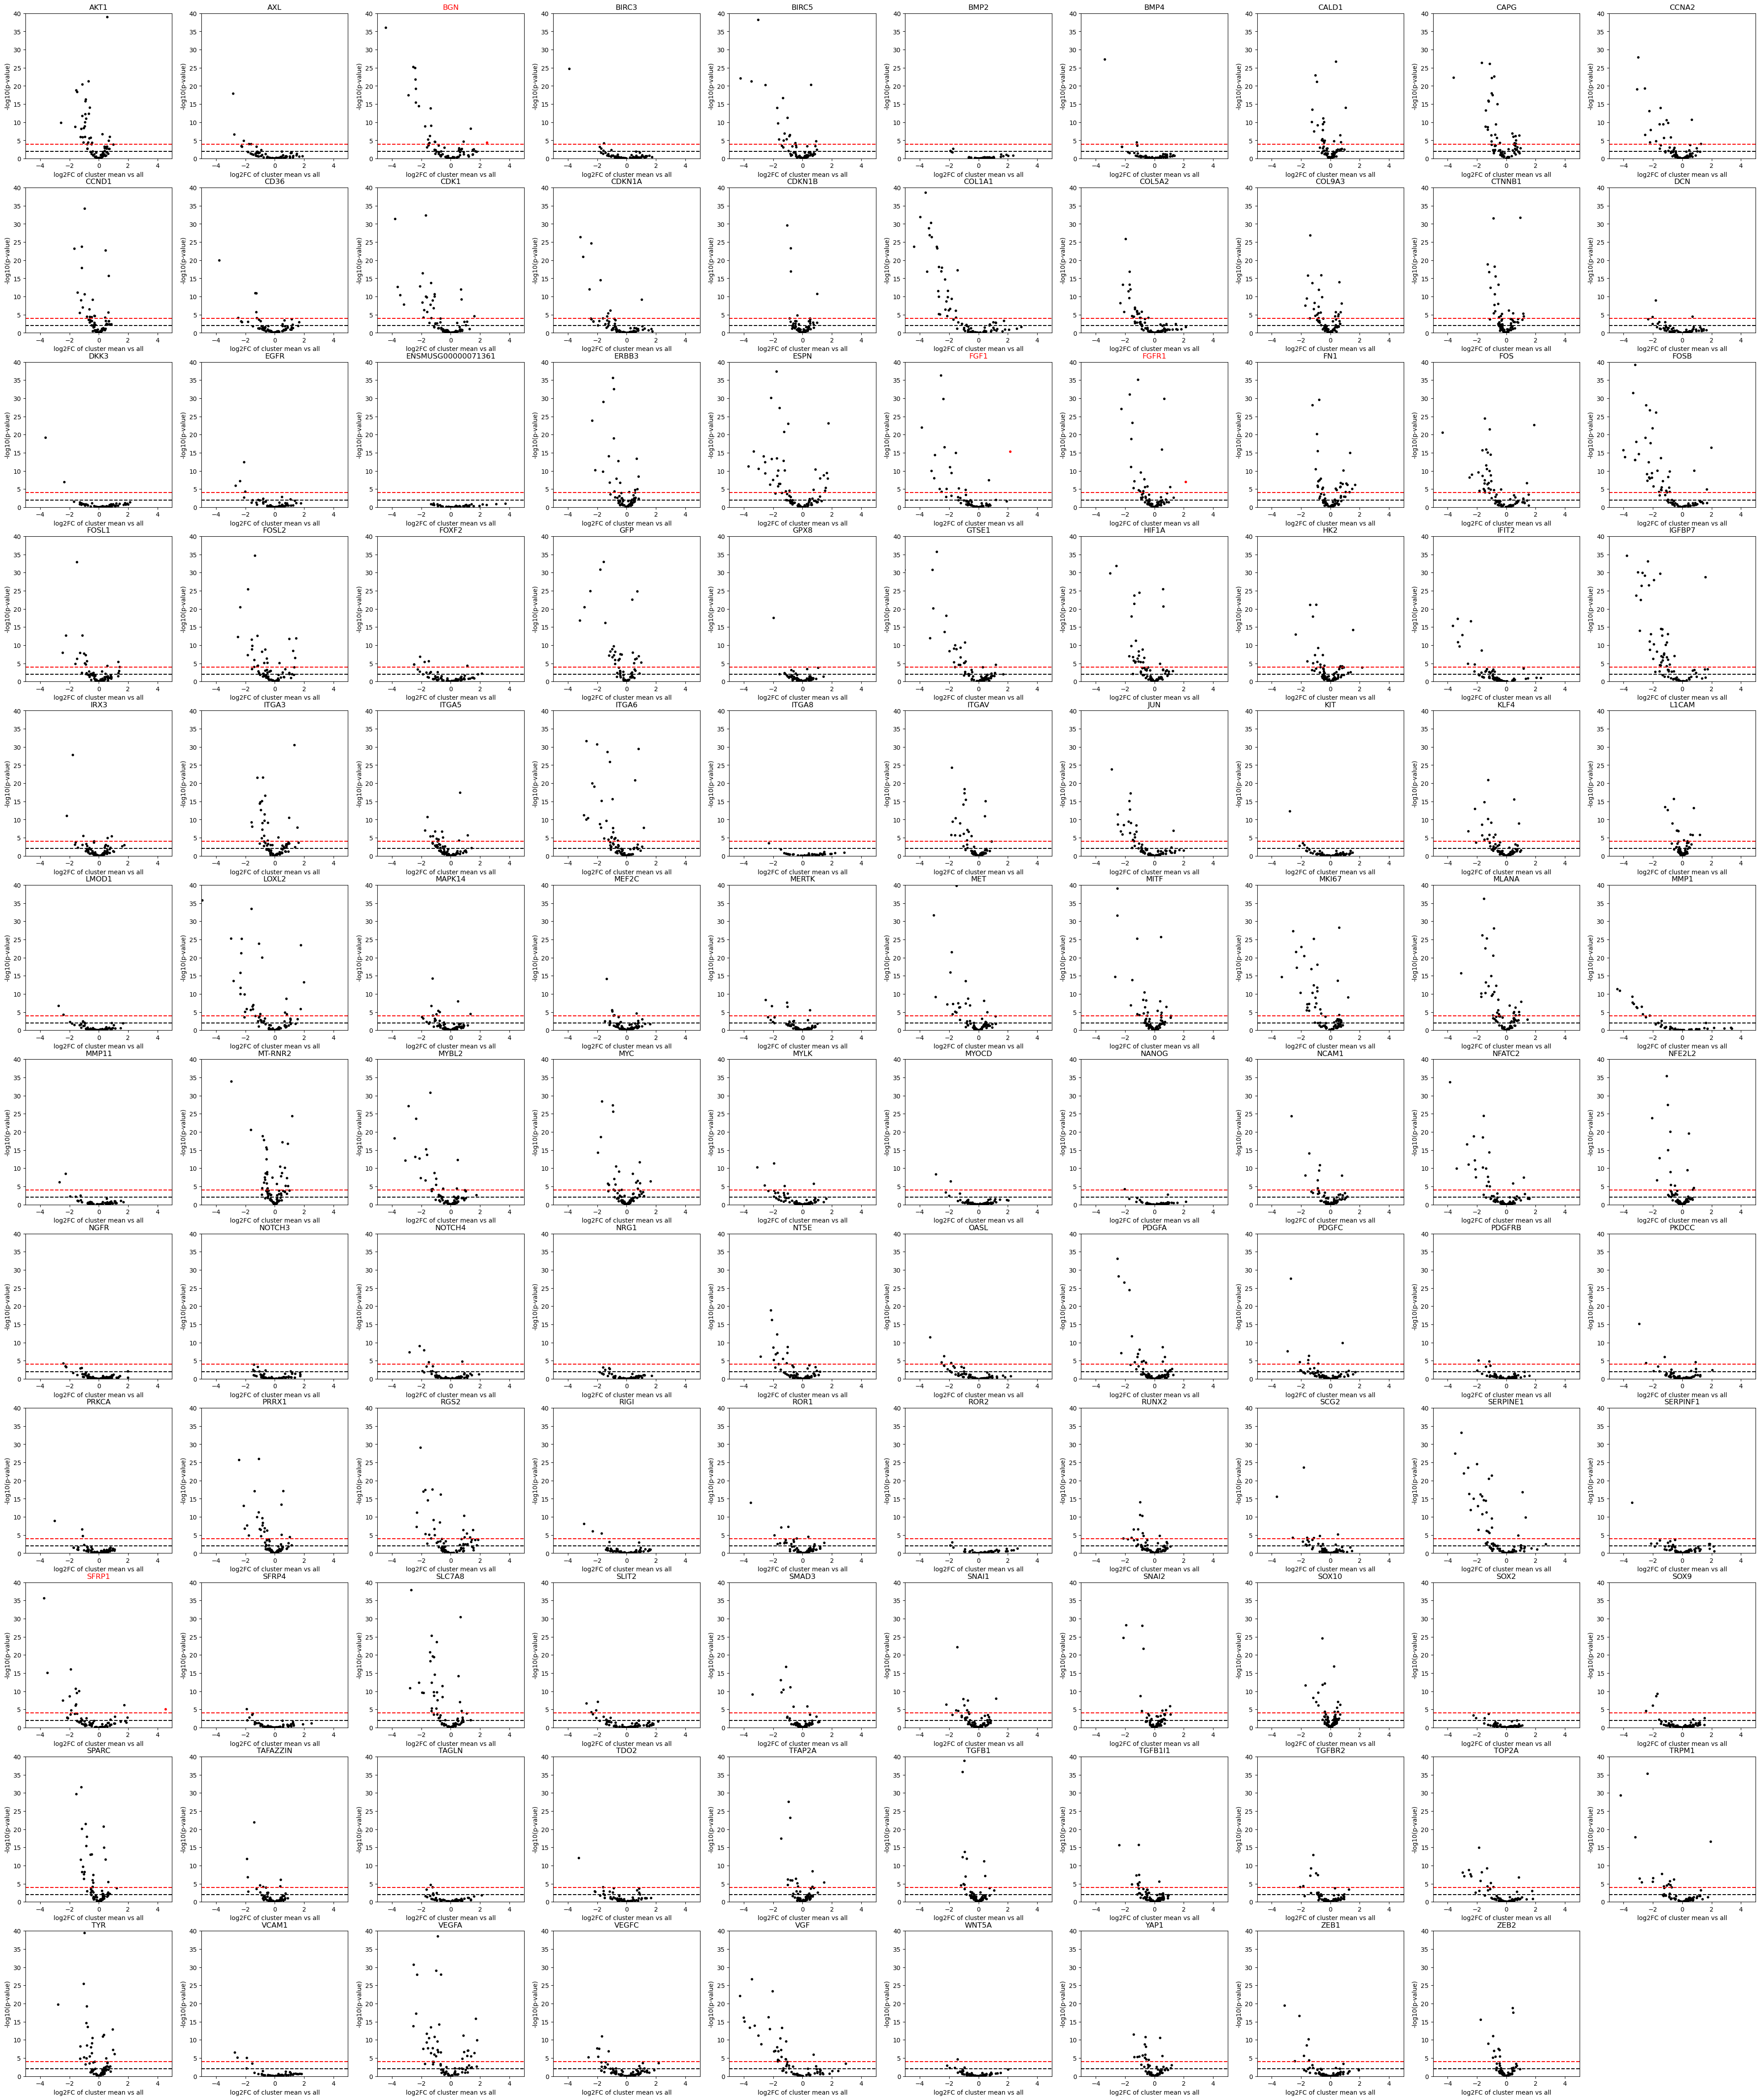

In [40]:
# for gene in 

gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

gene_list = adata_genes.var_names

plt.figure(figsize=(5*10,5*12))
for g,gene in enumerate(gene_list):

    
    plt.subplot(12,10,g+1)
    
    # plt.scatter(gene_by_bc_cluster_mean.loc[gene,:],-np.log10(gene_by_bc_cluster_here_p.loc[gene,:]))
    # plt.scatter(np.log2(gene_by_bc_cluster_mean.loc[gene,:]/np.mean(gene_by_bc_cluster_mean.loc[gene,:])),-np.log10(gene_by_bc_cluster_here_p.loc[gene,:]))

    colors_here = []

    for fc,p in zip(gene_by_bc_cluster_log2fc.loc[gene,:],-np.log10(gene_by_bc_cluster_here_p.loc[gene,:])):
        if fc > 2 and p > -np.log10(0.01/100):
            colors_here.append('r')
        else:
            colors_here.append('k')

    if colors_here.count('r') > 0:
        plt.title(gene,color='r')
    else:
        plt.title(gene,color='k')
        
    plt.scatter(gene_by_bc_cluster_log2fc.loc[gene,:],-np.log10(gene_by_bc_cluster_here_p.loc[gene,:]),marker='.',c=colors_here)
    plt.axhline(y=-np.log10(0.01),color='k',linestyle='--')
    plt.axhline(y=-np.log10(0.01/100),color='r',linestyle='--')
    # plt.axvline(np.mean(gene_by_bc_cluster_mean.loc[gene,:]),color='gray',linestyle='--')

    # plt.xlabel('Mean number of spots in cluster')


    plt.xlabel('log2FC of cluster mean vs all')
    plt.ylabel('-log10(p-value)')

    plt.xlim(-5,5)
    plt.ylim(0,40)

plt.savefig('plots/clone_gene_expression_volcano.png',bbox_inches='tight',dpi=300)
# plt.yscale('log')

In [41]:

# functions = [grouped_obs_mean,grouped_obs_median,grouped_obs_sum_squares,grouped_obs_fraction,grouped_obs_fraction_quantile,grouped_obs_ttest]
# names = ['mean','median','sum_squares','fraction','fraction_90','t_statistic']

functions = [grouped_obs_mean,grouped_obs_sum_squares]
names = ['mean','sum_squares']

gene_by_bc_cluster = grouped_obs_mean(confident_clusters,'bc_cluster')

all_entropy = pd.DataFrame(index=gene_by_bc_cluster.index)
gene_by_cluster_proportion_dict = {}
gene_by_cluster_measure_dict = {}

for name,func in zip(names,functions):

    print(name,func)
    gene_by_bc_cluster_here = func(confident_clusters,'bc_cluster')
    print(gene_by_bc_cluster_here.values[:3,:3])

    gene_by_cluster_measure_dict[name] = gene_by_bc_cluster_here
    
    gene_by_bc_cluster_proportion = gene_by_bc_cluster_here.div(gene_by_bc_cluster_here.sum(axis=1,skipna=True),axis=0)
    gene_by_bc_cluster_proportion = gene_by_bc_cluster_proportion.dropna()
    gene_by_cluster_proportion_dict[name] = gene_by_bc_cluster_proportion
    
    shannon_entropy_method = -(gene_by_bc_cluster_proportion*np.log(gene_by_bc_cluster_proportion)).sum(axis=1)
    all_entropy[name] = shannon_entropy_method

all_entropy['gene'] = all_entropy.index



mean <function grouped_obs_mean at 0x4cf6e1310>
[[2.         1.97959184 3.31034483]
 [0.02906977 0.         0.0862069 ]
 [2.47674419 0.30612245 5.12068966]]
sum_squares <function grouped_obs_sum_squares at 0x4cf6e13a0>
[[9.20930233e+00 9.65306122e+00 1.96896552e+01]
 [4.06976744e-02 0.00000000e+00 1.89655172e-01]
 [2.93372093e+01 6.73469388e-01 1.27155172e+02]]


/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [42]:
# all_entropy[all_entropy['fraction'] < all_entropy['fraction'].quantile(0.1)]

print(all_entropy['mean'].quantile(0.05))
print(all_entropy['sum_squares'].quantile(0.05))

q = 0.1

# all_entropy[(all_entropy['sum_squares'] < all_entropy['sum_squares'].quantile(q)) | 
#             (all_entropy['mean'] < all_entropy['mean'].quantile(q)) | 
#             (all_entropy['fraction'] < all_entropy['fraction'].quantile(q)) |
#             (all_entropy['fraction_90'] < all_entropy['fraction_90'].quantile(q)) |
#             (all_entropy['median'] < all_entropy['median'].quantile(q)) | 
#             (all_entropy['t_statistic'] > all_entropy['t_statistic'].quantile(1-q)) | 
#             ].sort_values('sum_squares')

# all_entropy[(all_entropy['sum_squares'] < all_entropy['sum_squares'].quantile(q)) | 
#             (all_entropy['mean'] < all_entropy['mean'].quantile(q)) | 
#             (all_entropy['fraction'] < all_entropy['fraction'].quantile(q)) |
#             (all_entropy['fraction_90'] < all_entropy['fraction_90'].quantile(q)) |
#             (all_entropy['median'] < all_entropy['median'].quantile(q)) | 
#             (all_entropy['t_statistic'] > all_entropy['t_statistic'].quantile(1-q))
#             ].sort_values('t_statistic')

all_entropy[(all_entropy['sum_squares'] < all_entropy['sum_squares'].quantile(q)) | 
            (all_entropy['mean'] < all_entropy['mean'].quantile(q)) 
            # (all_entropy['fraction'] < all_entropy['fraction'].quantile(q)) |
            # (all_entropy['fraction_90'] < all_entropy['fraction_90'].quantile(q)) |
            # (all_entropy['median'] < all_entropy['median'].quantile(q)) | 
            # (all_entropy['t_statistic'] > all_entropy['t_statistic'].quantile(1-q))
            ].sort_values('mean')


3.917262319152169
3.2242826691198228


mean  sum_squares                gene
MMP1                3.269822     2.238336                MMP1
ENSMUSG00000071361  3.373312     2.614535  ENSMUSG00000071361
ITGA8               3.653414     3.650699               ITGA8
SFRP1               3.703989     1.946839               SFRP1
ROR2                3.758936     3.759932                ROR2
COL1A1              3.883459     3.238852              COL1A1
VGF                 3.921018     3.093163                 VGF
BMP2                3.966614     3.968113                BMP2
NANOG               3.971810     3.972219               NANOG
SLIT2               4.002685     3.890577               SLIT2
IFIT2               4.028008     2.720277               IFIT2
SFRP4               4.034395     3.999064               SFRP4
OASL                4.036734     3.061766                OASL
IGFBP7              4.039421     3.314798              IGFBP7
SERPINE1            4.082541     3.372536            SERPINE1
BIRC3               4.117632     3.543124               BIRC3
CDKN1A              4.177430     3.462719              CDKN1A
FOS                 4.189200     3.545838                 FOS

Text(0, 0.5, 'Proportion of sum_squares expression from each cluster')

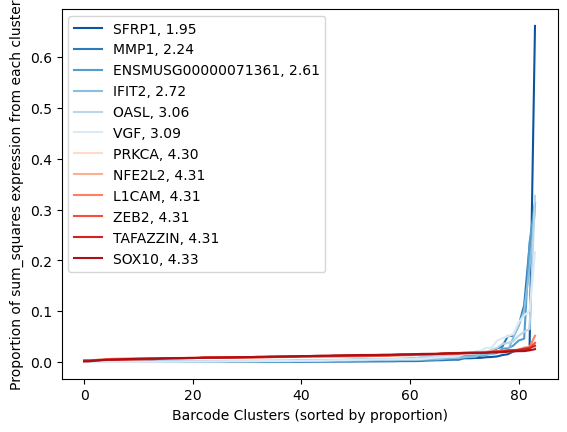

In [43]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'

# how = 'fraction_90'
how = 'sum_squares'
# how = 'median'

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.05)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',6)

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_proportion_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.95)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Reds',6)

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_proportion_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Proportion of {how} expression from each cluster')


Text(0, 0.5, 'Mean mean expression from each cluster')

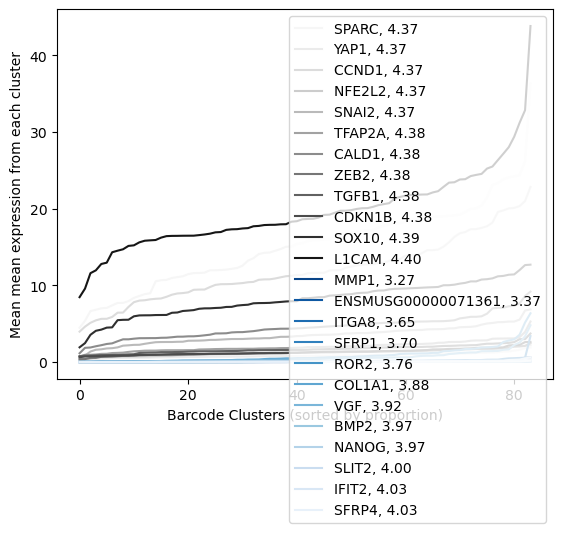

In [44]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'
# how = 'fraction_50'

def to_z_score(data):
    return (data - data.mean())/data.std()

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.9)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Greys',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_measure_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.1)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_measure_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Mean {how} expression from each cluster')


Text(0, 0.5, 'Z-score of mean expression from each cluster')

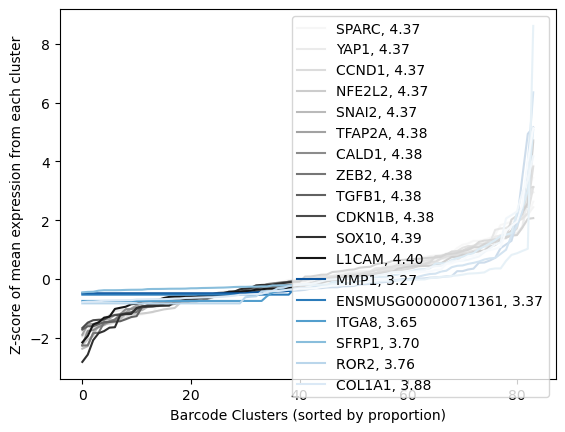

In [45]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'
# how = 'sum_squares'
# how = 'fraction_90'

def to_z_score(data):
    return (data - data.mean())/data.std()

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.9)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Greys',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(to_z_score(gene_by_cluster_measure_dict[how].loc[gene])),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.05)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',6)

for gene in gene_list:
    plt.plot(sorted(to_z_score(gene_by_cluster_measure_dict[how].loc[gene])),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Z-score of {how} expression from each cluster')


In [46]:
avg_gene_by_bc_cluster = grouped_obs_mean(confident_clusters,'bc_cluster')

In [47]:
sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])
merged_gdf = sg_obj.gdf.merge(cell_gene_table_df, on='object_id', how='left')

In [129]:
gene_of_interest = 'SFRP1'
how = 'fraction_90'

print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

top_to_plot = 1
threshold = 0.02

props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

top_to_plot = min([sum(props>threshold),top_to_plot])

clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

for rank,(cluster_of_interest,proportion) in enumerate(zip(clusters_of_interest,proportions_of_interest)): 

    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
    print(cluster_of_interest,len(cluster_cells),cluster_cells)

    central_ix = int(len(cluster_cells)/2)

    cell_id = cluster_cells[central_ix]

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

    sg_obj.gdf['object_id'] = sg_obj.gdf.index

    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

    print(np.unique(gene_names))

    fig = plt.figure(figsize=(10,10))

    vmin = 0
    vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])

    ax = fig.add_subplot(221)
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                                annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                                focal_outline_color='k',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.5,
                                exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} barcodes')

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    ax = fig.add_subplot(223)

    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

    rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    ax = fig.add_subplot(224)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                                norm=norm,
                                orientation='horizontal')
    cb1.set_label('Spots per cell')
    
    ax = fig.add_subplot(222)

    gene_names = [gene_of_interest]

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    # tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
    #                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
    #                             focal_outline_color='r',other_outline_color='gray',
    #                             interior_marker='.',single_mode=False,lw=0.5,
    #                             exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}\nRank:{rank+1}, Proportion:{proportion:.2f}')

    vmin = 0
    vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    print('VRange',vmin,vmax)

    # other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

    bbox = box(xmin,ymin,xmax,ymax)

    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters.index)]

    # print(merged_gdf_focal.shape)

    merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]
    
    print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.savefig(f'plots/cluster_intrinsic_expression_{how}_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

NameError: name 'gene_by_cluster_proportion_dict' is not defined

512 366 ['15863', '16177', '16209', '16438', '16456', '16489', '16433', '16448', '16523', '16622', '16783', '16892', '16881', '16907', '16977', '16904', '16972', '16986', '17049', '17172', '17080', '17171', '17101', '17243', '17190', '17249', '17363', '17319', '17333', '17315', '17357', '17510', '17429', '17574', '17646', '17547', '17605', '17707', '17716', '17727', '17711', '17814', '17736', '17739', '17765', '17846', '17923', '17878', '17851', '17811', '18037', '18062', '17929', '18023', '18076', '18093', '18109', '18154', '18094', '18107', '18250', '18332', '18339', '18217', '18329', '18350', '18322', '18453', '18444', '18578', '18551', '18613', '18722', '18675', '18700', '18605', '18754', '18759', '18745', '18763', '18732', '18869', '18743', '18901', '18928', '18963', '18907', '18858', '18912', '19014', '18950', '19050', '18993', '19109', '19117', '19116', '19211', '19130', '19248', '19256', '19258', '19282', '19340', '19353', '19288', '19348', '19402', '19279', '19358', '19342', '

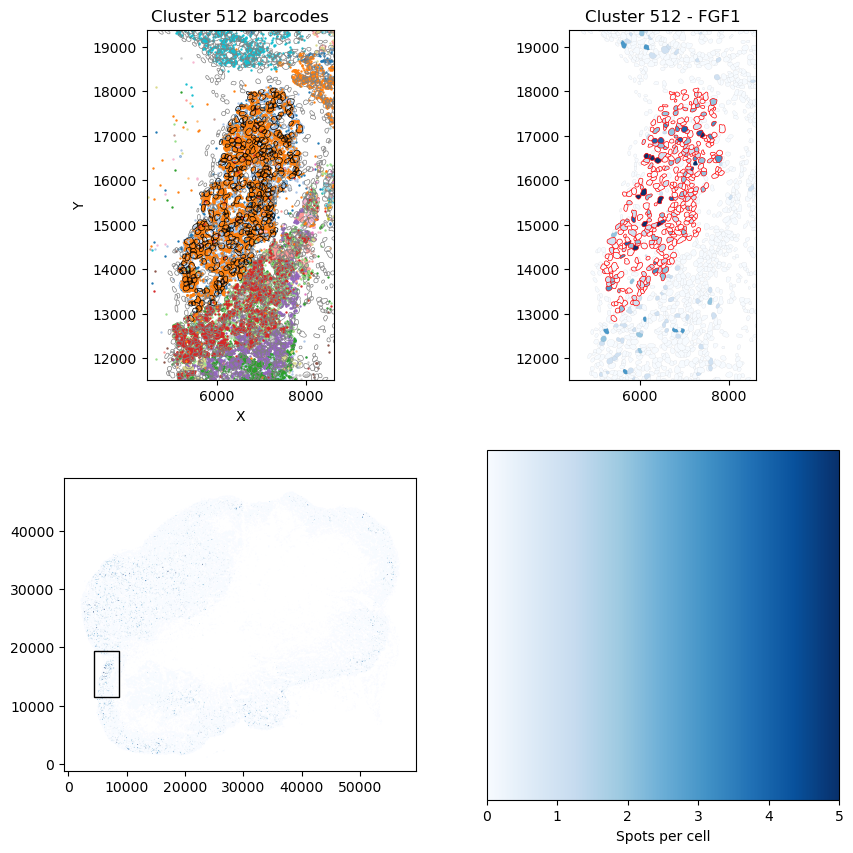

In [135]:
# gene_of_interest = 'SFRP1'
# how = 'fraction_90'

# print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# # clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

# top_to_plot = 1
# threshold = 0.02

# props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

# top_to_plot = min([sum(props>threshold),top_to_plot])

# clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
# proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

how = 'p_val+FC'
# gene_of_interest = 'FGFR1'
gene_of_interest = 'SFRP1'
gene_of_interest = 'FGF1'
cluster_of_interest = 512



cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
print(cluster_of_interest,len(cluster_cells),cluster_cells)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

sg_obj.gdf['object_id'] = sg_obj.gdf.index

gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

print(np.unique(gene_names))

fig = plt.figure(figsize=(10,10))

vmin = 0
vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])

ax = fig.add_subplot(221)
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                            annotate=False,image_scale=0.5,label=f'in cluster {cluster_of_interest}',
                            focal_outline_color='k',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.5,
                            exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} barcodes')

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(224)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('Spots per cell')

ax = fig.add_subplot(222)

gene_names = [gene_of_interest]

# gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

# tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
#                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
#                             focal_outline_color='r',other_outline_color='gray',
#                             interior_marker='.',single_mode=False,lw=0.5,
#                             exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}')

vmin = 0
vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
print('VRange',vmin,vmax)

# other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters.index)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]

print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.savefig(f'plots/cluster_intrinsic_expression_{how}_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
# sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [ ]:
for 

merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

<AxesSubplot: >

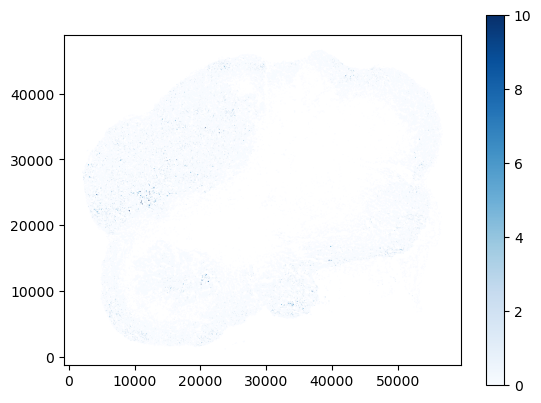

In [1046]:
gene_of_interest = 'SFRP1'
how = 'fraction_90'

print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

top_to_plot = 1
threshold = 0.02

props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

top_to_plot = min([sum(props>threshold),top_to_plot])

clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

for rank,(cluster_of_interest,proportion) in enumerate(zip(clusters_of_interest,proportions_of_interest)): 

    vmin = 0
    vmax = 10

    fig,ax = plt.figure(figsize=(10,5))

    plt.subplot(222)
    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=True,vmin=vmin,vmax=vmax)

    plt.subplot(221)
    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=True,vmin=vmin,vmax=vmax)



<AxesSubplot: >

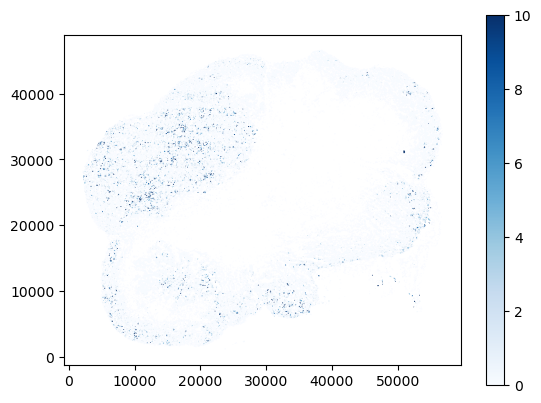

In [1052]:
merged_gdf.plot(column='VGF', cmap='Blues',vmax=10, legend=True)

In [482]:
adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs.index
merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]

In [48]:
extrinsic_entropy = pd.read_csv('extrinsic_entropy_per_gene.csv',names=['gene','extrinsic_entropy','extrinsic_entropy_normalized'],header=0)

extrinsic_score = pd.read_csv('snr_values.csv',names=['gene','extrinsic_snr_score'],header=0)

# extrinsic_pvals = 


In [49]:
extrinsic_score 

gene  extrinsic_snr_score
0     AKT1            10.017756
1      AXL             5.467886
2      BGN             6.338641
3    BIRC3             8.622360
4    BIRC5             7.376454
..     ...                  ...
114    VGF             6.481121
115  WNT5A             4.740391
116   YAP1             6.854806
117   ZEB1             6.616546
118   ZEB2             5.135854

[119 rows x 2 columns]

Index(['AKT1', 'AXL', 'BGN', 'BIRC3', 'BIRC5', 'BMP2', 'BMP4', 'CALD1', 'CAPG',
       'CCNA2',
       ...
       'TRPM1', 'TYR', 'VCAM1', 'VEGFA', 'VEGFC', 'VGF', 'WNT5A', 'YAP1',
       'ZEB1', 'ZEB2'],
      dtype='object', length=119)

In [68]:
## loading extrinsic p-values from KS-test

ks_score_directory = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/ks_scores'

extrinsic_pvals_dict = {}
extrinsic_log2fc_dict = {}

for gene in all_entropy.index:

    ks_gene = pd.read_csv(f'{ks_score_directory}/{gene}_ks_data.csv',names=['log2FoldChange','p_value','-log10p'],header=0)

    extrinsic_pvals_dict[gene] = ks_gene['p_value']
    extrinsic_log2fc_dict[gene] = ks_gene['log2FoldChange']


extrinsic_pvals_df = pd.DataFrame.from_dict(extrinsic_pvals_dict,orient='index')
extrinsic_log2fc_df = pd.DataFrame.from_dict(extrinsic_log2fc_dict,orient='index')
# extrinsic_pvals = pd.read_csv('ks_test_pvals.csv',names=['gene','extrinsic_pval'],header=0)

In [70]:
extrinsic_pvals_df.loc['VEGFA']

0     0.161808
1     0.407491
2     0.067162
3     0.379306
4     0.989433
5     0.441816
6     0.970714
7     1.000000
8     0.677508
9     0.005268
10    0.325385
11    0.999931
12    0.846374
13    0.561361
14    0.284552
15    0.143753
16    0.001823
17    0.321865
18    0.017798
19    0.020844
20    0.181436
21    0.124968
22    0.002997
23    0.676234
24    0.618319
Name: VEGFA, dtype: float64

In [77]:
extrinsic_log2fc_df.loc['VEGFA']

0    -0.208614
1    -0.165183
2    -0.258784
3    -0.103276
4    -0.108513
5    -0.138932
6    -0.036847
7     0.043348
8     0.008411
9     0.065830
10   -0.157337
11   -0.018560
12    0.027987
13    0.051623
14    0.165600
15    0.082733
16    0.218850
17    0.092517
18    0.251593
19    0.224097
20    0.293684
21    0.277771
22    0.307374
23    0.117325
24    0.101351
Name: VEGFA, dtype: float64

In [71]:
# shannon_entropy = all_entropy['mean']

# intrinsic_entropy = pd.DataFrame(shannon_entropy,columns=['intrinsic_entropy'])

intrinsic_entropy = all_entropy
intrinsic_entropy['intrinsic_entropy'] = all_entropy['mean']
intrinsic_entropy['gene'] = intrinsic_entropy.index
intrinsic_entropy['intrinsic_entropy_normalized'] = (intrinsic_entropy['intrinsic_entropy']-intrinsic_entropy['intrinsic_entropy'].min())/(intrinsic_entropy['intrinsic_entropy'].max()-intrinsic_entropy['intrinsic_entropy'].min())

ex_in_entropy = pd.merge(extrinsic_score,intrinsic_entropy[['gene','intrinsic_entropy','intrinsic_entropy_normalized']],on='gene')

In [72]:
intrinsic_entropy['intrinsic_entropy_normalized'] 

AKT1     0.948547
AXL      0.698834
BGN      0.761587
BIRC3    0.750972
BIRC5    0.912679
           ...   
VGF      0.576816
WNT5A    0.784992
YAP1     0.975617
ZEB1     0.812498
ZEB2     0.985753
Name: intrinsic_entropy_normalized, Length: 119, dtype: float64

In [73]:
ex_in_entropy['intrinsic_percentile'] = ex_in_entropy['intrinsic_entropy'].rank(pct=True)
ex_in_entropy['extrinsic_percentile'] = ex_in_entropy['extrinsic_snr_score'].rank(pct=True)

ex_in_entropy['intrinsic_z'] = -1*(ex_in_entropy['intrinsic_entropy']-ex_in_entropy['intrinsic_entropy'].median())/ex_in_entropy['intrinsic_entropy'].std()
ex_in_entropy['extrinsic_z'] = (ex_in_entropy['extrinsic_snr_score']-ex_in_entropy['extrinsic_snr_score'].median())/ex_in_entropy['extrinsic_snr_score'].std()

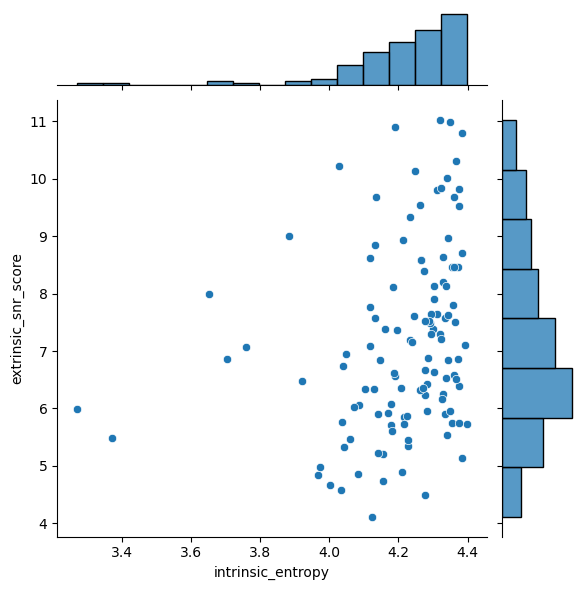

In [74]:
sns.jointplot(ex_in_entropy,x='intrinsic_entropy',y='extrinsic_snr_score')
# label outlier genes in 25th percentile of intrinsic entropy of either entropy measure
outliers = ex_in_entropy[(ex_in_entropy['intrinsic_entropy'] < ex_in_entropy['intrinsic_entropy'].quantile(0.15)) | (ex_in_entropy['extrinsic_snr_score'] < ex_in_entropy['extrinsic_snr_score'].quantile(0.15))]

# for i in outliers.index:
#     plt.text(all_entropy.loc[i,'intrinsic_entropy'],all_entropy.loc[i,'extrinsic_entropy'],all_entropy.loc[i,'gene'])

In [75]:
ex_in_entropy

gene  extrinsic_snr_score  intrinsic_entropy  \
0     AKT1            10.017756           4.340685   
1      AXL             5.467886           4.058771   
2      BGN             6.338641           4.129615   
3    BIRC3             8.622360           4.117632   
4    BIRC5             7.376454           4.300191   
..     ...                  ...                ...   
114    VGF             6.481121           3.921018   
115  WNT5A             4.740391           4.156039   
116   YAP1             6.854806           4.371245   
117   ZEB1             6.616546           4.187091   
118   ZEB2             5.135854           4.382687   

     intrinsic_entropy_normalized  intrinsic_percentile  extrinsic_percentile  \
0                        0.948547              0.789916              0.941176   
1                        0.698834              0.142857              0.134454   
2                        0.761587              0.218487              0.352941   
3                        0.750972              0.201681              0.815126   
4                        0.912679              0.630252              0.596639   
..                            ...                   ...                   ...   
114                      0.576816              0.058824              0.394958   
115                      0.784992              0.285714              0.042017   
116                      0.975617              0.915966              0.487395   
117                      0.812498              0.344538              0.436975   
118                      0.985753              0.966387              0.084034   

     intrinsic_z  extrinsic_z  
0      -0.415016     1.944723  
1       1.114351    -0.877240  
2       0.730024    -0.337172  
3       0.795032     1.079258  
4      -0.195339     0.306510  
..           ...          ...  
114     1.861651    -0.248802  
115     0.586679    -1.328454  
116    -0.580805    -0.017031  
117     0.418219    -0.164807  
118    -0.642879    -1.083176  

[119 rows x 8 columns]

In [76]:
gene_by_bc_cluster_here_p

8.0           10.0      16.0          17.0      26.0    \
AKT1   7.592214e-01  8.308160e-01  0.002206  2.187442e-01  0.024621   
AXL    3.356562e-02  0.000000e+00  0.675871  7.583279e-01  0.321655   
BGN    1.724170e-02  3.921040e-16  0.010229  1.331236e-01  0.050195   
BIRC3  1.556486e-01  9.186527e-01  0.644193  4.860049e-01  0.342985   
BIRC5  1.256298e-01  8.279773e-01  0.027074  3.218473e-01  0.299200   
...             ...           ...       ...           ...       ...   
VGF    0.000000e+00  5.786360e-05  0.038518  6.741634e-12  0.151528   
WNT5A  6.857323e-01  8.879598e-01  0.323198  0.000000e+00  0.886065   
YAP1   8.324191e-06  5.464478e-01  0.619544  2.167666e-02  0.027709   
ZEB1   3.614701e-20  2.594095e-01  0.421705  1.753541e-01  0.189288   
ZEB2   9.180977e-12  3.515400e-04  0.087634  2.857688e-01  0.806849   

             28.0      31.0          39.0      42.0          49.0    ...  \
AKT1   7.041575e-02  0.137494  1.059276e-01  0.000013  1.968460e-02  ...   
AXL    5.669934e-04  0.000107  2.604521e-02  0.315481  6.166359e-02  ...   
BGN    7.163465e-02  0.067495  2.196022e-05  0.000054  6.228507e-07  ...   
BIRC3  3.683089e-01  0.865974  4.726334e-03  0.873253  2.991586e-01  ...   
BIRC5  4.004284e-01  0.210508  1.966904e-01  0.810460  2.317045e-01  ...   
...             ...       ...           ...       ...           ...  ...   
VGF    1.078775e-08  0.833278  2.272484e-03  0.012348  1.132060e-07  ...   
WNT5A  7.664647e-01  0.782047  6.947929e-01  0.109213  8.360316e-01  ...   
YAP1   6.318089e-02  0.099608  3.224556e-05  0.102141  1.604550e-02  ...   
ZEB1   6.154863e-01  0.648650  9.770392e-03  0.062704  6.460546e-01  ...   
ZEB2   8.509175e-02  0.255259  6.397719e-08  0.555713  4.532912e-02  ...   

         1214.0        1254.0    1315.0        1383.0        1394.0    1408.0  \
AKT1   0.023983  1.887947e-09  0.389929  4.914364e-02  6.089887e-13  0.000114   
AXL    0.719866  0.000000e+00  0.297256  5.007258e-01  3.157476e-01  0.632981   
BGN    0.002301  1.412592e-01  0.142873  9.565939e-37  4.306687e-03  0.255240   
BIRC3  0.800131  0.000000e+00  0.519432  8.576819e-01  7.097265e-03  0.724665   
BIRC5  0.517823  5.788969e-22  0.901590  8.520879e-01  9.852625e-01  0.568490   
...         ...           ...       ...           ...           ...       ...   
VGF    0.001260  8.330862e-23  0.033192  2.078678e-01  1.060467e-13  0.983216   
WNT5A  0.665118  4.627191e-01  0.000000  0.000000e+00  3.423411e-01  0.000000   
YAP1   0.014483  7.106515e-04  0.227398  9.534278e-01  5.919977e-01  0.370737   
ZEB1   0.015847  0.000000e+00  0.709908  2.789555e-01  2.301234e-01  0.939993   
ZEB2   0.000004  3.369705e-01  0.020306  6.092448e-01  8.597579e-01  0.049106   

             1510.0    1534.0    1590.0    3176.0  
AKT1   1.990724e-03  0.674637  0.904774  0.017030  
AXL    7.395298e-01  0.014468  0.000000  0.607210  
BGN    9.057747e-01  0.874251  0.916258  0.000000  
BIRC3  4.694387e-01  0.144264  0.790386  0.279834  
BIRC5  1.124579e-05  0.916109  0.220170  0.319891  
...             ...       ...       ...       ...  
VGF    4.469865e-14  0.000083  0.827307  0.122366  
WNT5A  8.891531e-01  0.393680  0.000000  0.014633  
YAP1   3.849935e-01  0.420828  0.305613  0.778168  
ZEB1   1.725534e-01  0.010272  0.511484  0.666366  
ZEB2   9.803886e-01  0.301355  0.365340  0.300637  

[119 rows x 84 columns]

In [54]:
sns.set_color_codes('deep')

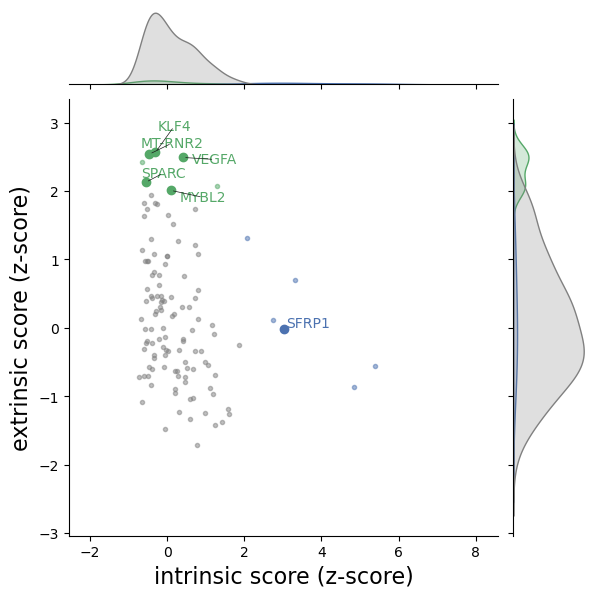

In [93]:
intrinsic_outliers = ex_in_entropy[(ex_in_entropy['intrinsic_z'] > 2)]
extrinsic_outliers = ex_in_entropy[(ex_in_entropy['extrinsic_z'] > 2)]

significant_intrinsic = ex_in_entropy.index[np.any(((gene_by_bc_cluster_here_p < 0.01/gene_by_bc_cluster_here_p.shape[1]) & (gene_by_bc_cluster_log2fc > 1 )),axis=1)]
significant_intrinsic = significant_intrinsic.values

# significant_extrinsic = ex_in_entropy.index[np.any(((extrinsic_pvals_df < 0.01/extrinsic_pvals_df.shape[1]) & (extrinsic_log2fc_df > 1 )),axis=1)]
significant_extrinsic = ex_in_entropy.index[np.any(((extrinsic_pvals_df < 0.01/extrinsic_pvals_df.shape[1])),axis=1)]
significant_extrinsic = significant_extrinsic.values

ex_in_entropy['outlier_status'] = ['both' if (i in intrinsic_outliers.index and i in extrinsic_outliers.index) else 'intrinsic' if i in intrinsic_outliers.index else 'extrinsic' if i in extrinsic_outliers.index else 'neither' for i in ex_in_entropy.index]
ex_in_entropy['significant_change'] = ['both' if (i in significant_intrinsic and i in significant_extrinsic) else 'intrinsic' if i in significant_intrinsic else 'extrinsic' if i in significant_extrinsic else 'neither' for i in ex_in_entropy.index]

ex_in_entropy['real_outlier'] = [True if (out != 'neither' and sig != 'neither') else False for (out,sig) in ex_in_entropy[['outlier_status','significant_change']].values]

color_map = {'both':'r','intrinsic':'b','extrinsic':'g','neither':'gray'}


g = sns.jointplot(ex_in_entropy,x='intrinsic_z',y='extrinsic_z',hue='outlier_status',palette=color_map,marker='o')
# label outlier genes in 25th percentile of intrinsic entropy of either entropy measure
# outliers = ex_in_entropy[((ex_in_entropy['intrinsic_z'] > 1) | (ex_in_entropy['extrinsic_z'] > 1)) & ((ex_in_entropy['significant_change'] != 'neither'))]
outliers = ex_in_entropy[((ex_in_entropy['intrinsic_z'] > 2) | (ex_in_entropy['extrinsic_z'] > 2))  & (ex_in_entropy['real_outlier'] != False)]



plt.xlim(-6,1)
plt.ylim(-10,2)

g.ax_joint.cla()

#Generate some colors and markers

# marker_map = {'both':'o','intrinsic':'o','extrinsic':'o','neither':'.'}
# alpha_map = {'both':1.0,'intrinsic':1.0,'extrinsic':1.0,'neither':0.5}

marker_map = {True:'o',False:'.'}
alpha_map = {True:1.0,False:0.5}

colors = [color_map[out] for out in ex_in_entropy['outlier_status']]
markers = [marker_map[out] for out in ex_in_entropy['real_outlier']]
alphas = [alpha_map[out] for out in ex_in_entropy['real_outlier']]
# markers = ['x','o','v','^','<']*100

#Plot each individual point separately
for i,row in enumerate(ex_in_entropy[['intrinsic_z','extrinsic_z']].values):
    g.ax_joint.plot(row[0], row[1], color=colors[i], marker=markers[i],alpha=alphas[i])

g.set_axis_labels('intrinsic score (z-score)', 'extrinsic score (z-score)', fontsize=16)


texts = []
for i in outliers.index:
    texts.append(plt.text(ex_in_entropy.loc[i,'intrinsic_z'],ex_in_entropy.loc[i,'extrinsic_z'],ex_in_entropy.loc[i,'gene'],c=color_map[ex_in_entropy.loc[i,'outlier_status']]))

adjust_text(texts,
            # autoalign='y',
            # only_move={'points':'y', 'text':'y'}, 
            force_points=50,avoid_self=True,
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5))


plt.savefig('plots/extrinsic_vs_intrinsic_score_z.pdf',bbox_inches='tight')
plt.savefig('plots/extrinsic_vs_intrinsic_score_z.png',bbox_inches='tight',dpi=300)

In [83]:
significant_extrinsic

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [85]:
ex_in_entropy['gene'].values[significant_extrinsic]

array(['AKT1', 'BIRC5', 'CALD1', 'CAPG', 'CCND1', 'CTNNB1', 'ERBB3',
       'GFP', 'ITGA6', 'KLF4', 'LOXL2', 'MITF', 'MKI67', 'MLANA',
       'MT-RNR2', 'MYBL2', 'MYC', 'PRRX1', 'SLC7A8', 'SOX10', 'SPARC',
       'TYR'], dtype=object)

In [96]:
ex_in_entropy[ex_in_entropy['outlier_status']!='neither'].sort_values('intrinsic_entropy')

gene  extrinsic_snr_score  intrinsic_entropy  \
59                 MMP1             5.983669           3.269822   
22   ENSMUSG00000071361             5.480580           3.373312   
44                ITGA8             7.999150           3.653414   
90                SFRP1             6.855490           3.703989   
85                 ROR2             7.069555           3.758936   
15               COL1A1             8.997914           3.883459   
38                IFIT2            10.224358           4.028008   
112               VEGFA            10.899653           4.189065   
62                MYBL2            10.124181           4.247652   
48                 KLF4            11.018384           4.320765   
61              MT-RNR2            10.976701           4.349809   
100               SPARC            10.315002           4.366567   
105               TGFB1            10.786735           4.383380   

     intrinsic_entropy_normalized  intrinsic_percentile  extrinsic_percentile  \
59                       0.000000              0.008403              0.277311   
22                       0.091669              0.016807              0.142857   
44                       0.339778              0.025210              0.722689   
90                       0.384576              0.033613              0.495798   
85                       0.433247              0.042017              0.521008   
15                       0.543546              0.050420              0.865546   
38                       0.671585              0.092437              0.957983   
112                      0.814246              0.352941              0.983193   
62                       0.866141              0.478992              0.949580   
48                       0.930903              0.689076              1.000000   
61                       0.956629              0.823529              0.991597   
100                      0.971473              0.907563              0.966387   
105                      0.986366              0.974790              0.974790   

     intrinsic_z  extrinsic_z outlier_status significant_change  real_outlier  
59      5.394355    -0.557337      intrinsic            neither         False  
22      4.832928    -0.869367      intrinsic            neither         False  
44      3.313389     0.692724      intrinsic            neither         False  
90      3.039024    -0.016607      intrinsic          intrinsic          True  
85      2.740940     0.116162      intrinsic            neither         False  
15      2.065411     1.312187      intrinsic            neither         False  
38      1.281237     2.072864      extrinsic            neither         False  
112     0.407512     2.491702      extrinsic          intrinsic          True  
62      0.089681     2.010731      extrinsic          extrinsic          True  
48     -0.306954     2.565342      extrinsic          extrinsic          True  
61     -0.464514     2.539489      extrinsic               both          True  
100    -0.555424     2.129084      extrinsic          extrinsic          True  
105    -0.646636     2.421667      extrinsic            neither         False

In [608]:
import squidpy as sq

In [609]:
sq.gr.spatial_neighbors(adata_genes)

KeyError: 'Spatial basis `spatial` not found in `adata.obsm`.'

16.0      0.231631
195.0     0.038205
57.0      0.036288
155.0     0.034272
207.0     0.032863
            ...   
684.0     0.002211
55.0      0.001804
746.0     0.000868
1101.0    0.000741
256.0     0.000377
Name: SFRP1, Length: 84, dtype: float64
16 58 ['28140', '28279', '28729', '30256', '30446', '30561', '30762', '30823', '30807', '31023', '31084', '31076', '31476', '31595', '31648', '31749', '31632', '31665', '31816', '31860', '32300', '32342', '32452', '32534', '32536', '32578', '32852', '32881', '32762', '32817', '32873', '32960', '33102', '33160', '33206', '33174', '33204', '33256', '33239', '33406', '33482', '33565', '33547', '33515', '33599', '33669', '33640', '33642', '33629', '33780', '33911', '33871', '33990', '34141', '34203', '34375', '34772', '36023']
['bc_001' 'bc_003' 'bc_004' 'bc_006' 'bc_007' 'bc_008' 'bc_009' 'bc_010'
 'bc_014' 'bc_016' 'bc_022' 'bc_024' 'bc_027' 'bc_029' 'bc_031' 'bc_033'
 'bc_035' 'bc_039' 'bc_040' 'bc_041' 'bc_044' 'bc_048' 'bc_052' 'bc_056'
 'b

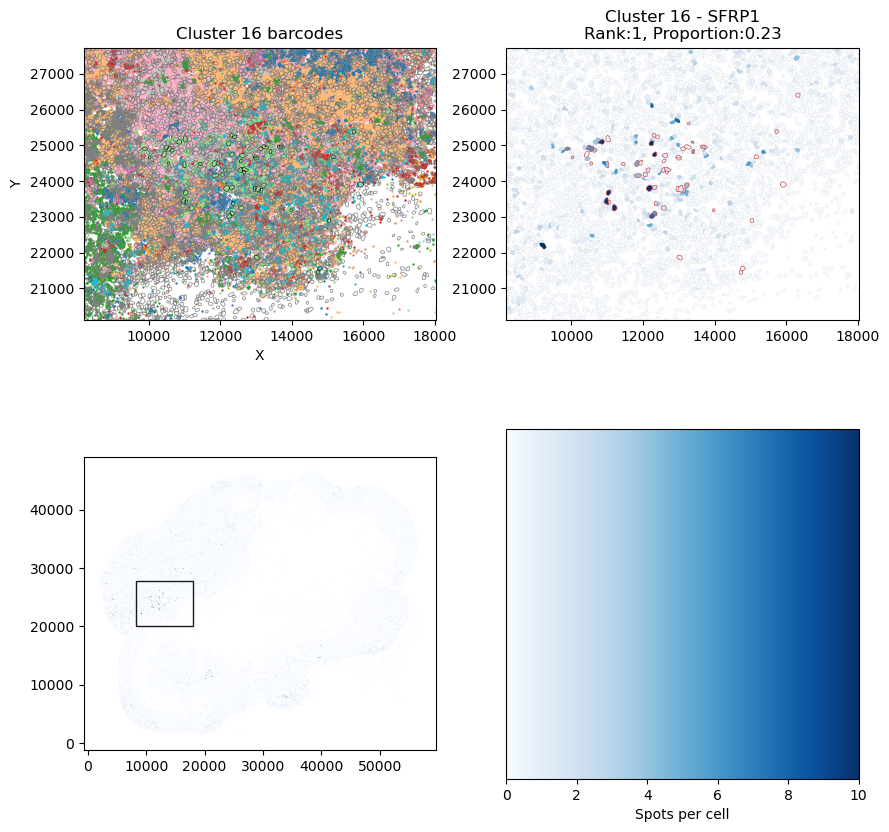

In [94]:
# gene_of_interest = 'FOSB'
# gene_of_interest = 'IGFBP7'
gene_of_interest = 'SFRP1'
how = 'mean'

print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

top_to_plot = 1
threshold = 0.02

props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

top_to_plot = min([sum(props>threshold),top_to_plot])

clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

for rank,(cluster_of_interest,proportion) in enumerate(zip(clusters_of_interest,proportions_of_interest)): 

    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
    print(cluster_of_interest,len(cluster_cells),cluster_cells)

    central_ix = int(len(cluster_cells)/2)

    cell_id = cluster_cells[central_ix]

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

    sg_obj.gdf['object_id'] = sg_obj.gdf.index

    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

    print(np.unique(gene_names))

    fig = plt.figure(figsize=(10,10))

    vmin = 0
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])

    ax = fig.add_subplot(221)
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                                annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                                focal_outline_color='k',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.5,
                                exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} barcodes')

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    ax = fig.add_subplot(223)

    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

    rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    ax = fig.add_subplot(224)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                                norm=norm,
                                orientation='horizontal')
    cb1.set_label('Spots per cell')
    
    ax = fig.add_subplot(222)

    gene_names = [gene_of_interest]

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    # tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
    #                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
    #                             focal_outline_color='r',other_outline_color='gray',
    #                             interior_marker='.',single_mode=False,lw=0.5,
    #                             exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}\nRank:{rank+1}, Proportion:{proportion:.2f}')

    # vmin = 0
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    # vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),10])
    print('VRange',vmin,vmax)

    # other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

    bbox = box(xmin,ymin,xmax,ymax)

    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters.index)]

    # print(merged_gdf_focal.shape)

    merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]
    
    print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.savefig(f'plots/cluster_intrinsic_expression_{how}_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

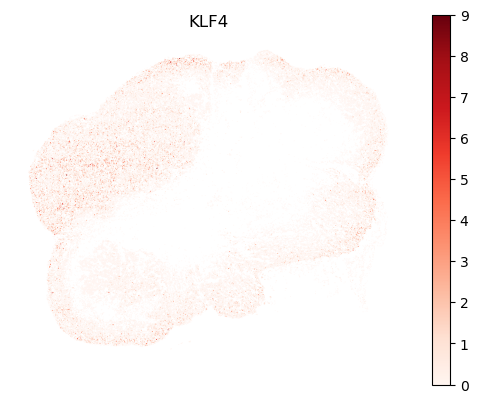

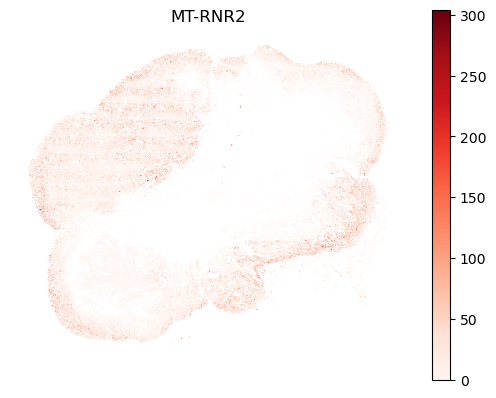

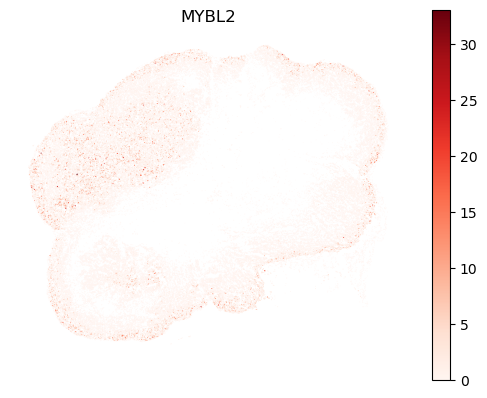

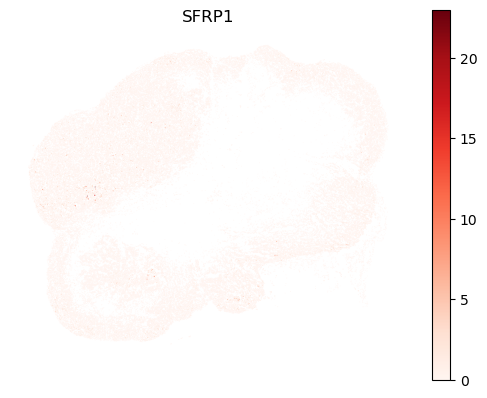

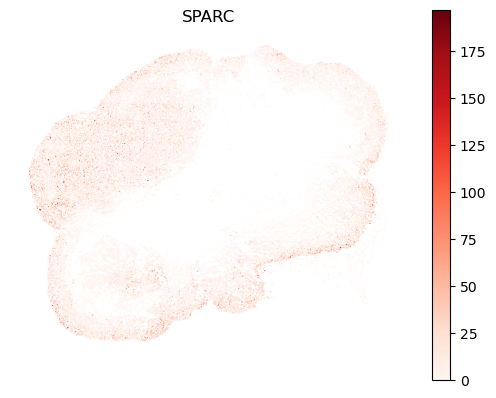

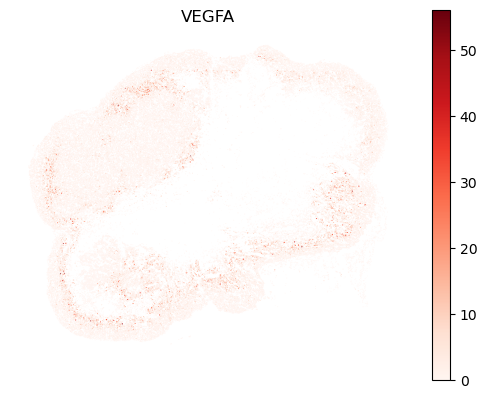

In [110]:
for gene in outliers.gene:
    # plt.text(ex_in_entropy.loc[gene,'intrinsic_z'],ex_in_entropy.loc[gene,'extrinsic_z'],gene)    
    # fig,ax = plt.subplots()
    fig = plt.figure()
    ax = plt.gca()
    # ax.set_facecolor('g')

    plt.title(gene)
    merged_gdf.plot(column=gene,cmap='Reds',ax=ax,legend=True,facecolor='gray')
    # ax.set_facecolor('gray')
    plt.axis('off')

In [99]:
outliers

gene  extrinsic_snr_score  intrinsic_entropy  \
48      KLF4            11.018384           4.320765   
61   MT-RNR2            10.976701           4.349809   
62     MYBL2            10.124181           4.247652   
90     SFRP1             6.855490           3.703989   
100    SPARC            10.315002           4.366567   
112    VEGFA            10.899653           4.189065   

     intrinsic_entropy_normalized  intrinsic_percentile  extrinsic_percentile  \
48                       0.930903              0.689076              1.000000   
61                       0.956629              0.823529              0.991597   
62                       0.866141              0.478992              0.949580   
90                       0.384576              0.033613              0.495798   
100                      0.971473              0.907563              0.966387   
112                      0.814246              0.352941              0.983193   

     intrinsic_z  extrinsic_z outlier_status significant_change  real_outlier  
48     -0.306954     2.565342      extrinsic          extrinsic          True  
61     -0.464514     2.539489      extrinsic               both          True  
62      0.089681     2.010731      extrinsic          extrinsic          True  
90      3.039024    -0.016607      intrinsic          intrinsic          True  
100    -0.555424     2.129084      extrinsic          extrinsic          True  
112     0.407512     2.491702      extrinsic          intrinsic          True